In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input ,Conv2D ,MaxPooling2D ,UpSampling2D ,Reshape ,Flatten
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.optimizers import Adam

from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
#read images
def read_img(path):
    imgs = glob(path +"/*.jpg")
    num = len(imgs)
    array_rgb = np.zeros([num , 64 , 64 ,3])
    array_gray = np.zeros([num , 64 , 64 ])
    
    i = 0
    for im in imgs:
        img = load_img(im , target_size=(64,64))
        img = img_to_array(img)
        img_gray = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)

        
        array_rgb[i :] =  img
        array_gray[i :] = img_gray
        i += 1
    
    return array_gray , array_rgb
    

In [4]:
path = "/kaggle/input/landscape-pictures/"

x_input , x_output = read_img(path)
print("X input shape :", x_input.shape)
print("X output shape :", x_output.shape)

X input shape : (4319, 64, 64)
X output shape : (4319, 64, 64, 3)


Input images


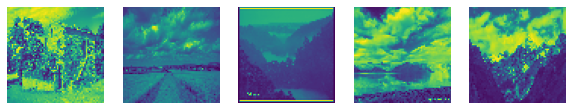

Output images


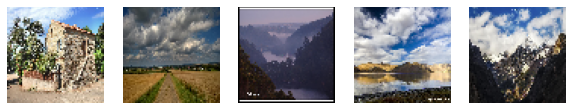

In [5]:
#visualize
print("Input images")
plt.figure(figsize = (10,4))
for i in range(5):
    plt.subplot(1,5, i+1)
    plt.imshow(x_input[i])
    plt.axis("off")
plt.show()    
    
print("Output images") 
plt.figure(figsize = (10,4))
for i in range(5):
    plt.subplot(1,5 ,i+1)
    plt.imshow(x_output[i].astype("int"))
    plt.axis("off")

plt.show()

In [6]:
#preprocessing
x_input = x_input.astype("float32") / 255.0
x_output = x_output.astype("float32") / 255.0

x_input = np.reshape(x_input , (len(x_input) , 64, 64 , 1))
x_output= np.reshape(x_output , (len(x_output) , 64, 64, 3))

In [7]:
#encoder
encoder_img_input = Input(shape = (64 , 64 , 1))

x = Conv2D(32 ,(3,3), activation = "relu" , padding = "same")(encoder_img_input)
x = MaxPooling2D((2,2), padding = "same")(x) #32,32,128

x = Conv2D(64 ,(3,3), activation = "relu", padding = "same")(x)
x = MaxPooling2D((2,2) ,padding = "same")(x) #16,16,64

x = Conv2D(128, (3,3) ,activation = "relu", padding = "same")(x)
x = MaxPooling2D((2,2), padding = "same")(x)#8,8,64

x = Conv2D(128 , (3,3) ,activation = "relu", padding = "same")(x) #8,8,32
x = MaxPooling2D((2,2), padding = "same")(x)#4,4,32

x = Flatten()(x)
x = Dense(4*4*16 , activation = "relu")(x)
encoded = Dense(4*4*4 , activation = "relu")(x) #latent space

encoder = Model(encoder_img_input, encoded , name = "encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0   

In [10]:
#decoder
x = Dense(4*4*16, activation = "relu")(encoded) 
x = Reshape((4,4,16) , input_shape = (4*4*16, ))(x)

x = UpSampling2D((2,2))(x) 
x = Conv2D(128 , (3,3) ,activation = "relu", padding = "same")(x) 

x = UpSampling2D((2,2))(x) 
x = Conv2D(128, (3,3) ,activation = "relu", padding = "same")(x)

x = UpSampling2D((2,2))(x) 
x = Conv2D(64 ,(3,3), activation = "relu", padding = "same")(x)

x = UpSampling2D((2,2))(x)
x = Conv2D(32 ,(3,3), activation = "relu" , padding = "same")(x)

decoded = Conv2D(3 ,(3,3), activation = "sigmoid" , padding = "same")(x)

#model
autoencoder = Model(encoder_img_input , decoded , name = "autoencoder")
autoencoder.compile(loss = "binary_crossentropy" , optimizer = Adam(learning_rate=0.0001,
                                                                   beta_1=0.5))

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         

In [11]:
#train
hist = autoencoder.fit(x_input, x_output, 
                epochs = 100,
                batch_size = 256,
                shuffle = True,
                validation_data = (x_input, x_output))

#model save
autoencoder.save_weights("autoencoderweights.h5")
encoder.save_weights("encoderweights.h5")

Epoch 1/100
17/17 [==============================] - 137s 8s/step - loss: 0.6861 - val_loss: 0.6622
Epoch 2/100
17/17 [==============================] - 136s 8s/step - loss: 0.6566 - val_loss: 0.6352
Epoch 3/100
17/17 [==============================] - 137s 8s/step - loss: 0.6319 - val_loss: 0.6181
Epoch 4/100
17/17 [==============================] - 135s 8s/step - loss: 0.6170 - val_loss: 0.6106
Epoch 5/100
17/17 [==============================] - 134s 8s/step - loss: 0.6105 - val_loss: 0.6087
Epoch 6/100
17/17 [==============================] - 133s 8s/step - loss: 0.6091 - val_loss: 0.6021
Epoch 7/100
17/17 [==============================] - 133s 8s/step - loss: 0.6014 - val_loss: 0.6003
Epoch 8/100
17/17 [==============================] - 133s 8s/step - loss: 0.5992 - val_loss: 0.6089
Epoch 9/100
17/17 [==============================] - 134s 8s/step - loss: 0.5996 - val_loss: 0.5955
Epoch 10/100
17/17 [==============================] - 133s 8s/step - loss: 0.5949 - val_loss: 0.5954